# YouTube Trending Videos Analysisl

**Research Question:** What patterns and factors determine a video's success on YouTube?

This notebook analyzes trending YouTube videos across multiple countries to identify:
- Key engagement metrics and patterns
- Optimal publishing strategies
- Category performance differences
- Factors correlating with video success

## Install Required Dependencies

Run this cell first to install all necessary packages.

In [78]:
# Install required packages
%pip install pandas numpy matplotlib seaborn

print("\nAll packages installed successfully!")

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.

All packages installed successfully!



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


## 1. Import Libraries and Setup

In [79]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import warnings

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Set figure size defaults
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("Libraries imported successfully")

Libraries imported successfully


## 2. Data Loading Functions

We'll create reusable functions to load and process data from multiple countries. To be a bit more specific with our findings I decided to consider only the western English speaking countries that have the really high number of users which our USA, Great Britan and Canada.
https://worldpopulationreview.com/country-rankings/youtube-users-by-country

In [ ]:
def load_category_mapping(country_code):
    """
    Load category ID to name mapping from JSON file.
    
    Parameters:
    country_code (str): Two-letter country code (e.g., 'US', 'CA')
    
    Returns:
    dict: Mapping of category_id to category_name
    """
    try:
        with open(f'../dataset/{country_code}_category_id.json', 'r', encoding='utf-8') as f:
            data = json.load(f)
        
        category_map = {}
        for item in data['items']:
            category_map[int(item['id'])] = item['snippet']['title']
        
        return category_map
    except FileNotFoundError:
        print(f"Warning: Category file for {country_code} not found")
        return {}

def load_videos_data(country_code):
    """
    Load video data for a specific country.
    
    Parameters:
    country_code (str): Two-letter country code
    
    Returns:
    DataFrame: Video data with country column added
    """
    try:
        df = pd.read_csv(f'../dataset/{country_code}videos.csv', 
                        encoding='utf-8', 
                        on_bad_lines='skip')
        df['country'] = country_code
        return df
    except FileNotFoundError:
        print(f"Warning: Video file for {country_code} not found")
        return pd.DataFrame()

def load_english_speaking_countries(countries):
    """
    Load and combine data from multiple countries using loops.
    
    Parameters:
    countries (list): List of country codes
    
    Returns:
    tuple: (combined_df, category_mappings)
    """
    all_data = []
    all_categories = {}
    
    for country in countries:
        print(f"Loading data for {country}...")
   
        df = load_videos_data(country)
        if not df.empty:
            all_data.append(df)
        
        categories = load_category_mapping(country)
        if categories:
            all_categories[country] = categories
    
    # Combine all dataframes
    if all_data:
        combined_df = pd.concat(all_data, ignore_index=True)
        print(f"\n✓ Loaded {len(combined_df):,} videos from {len(countries)} countries")
        return combined_df, all_categories
    else:
        return pd.DataFrame(), {}

# Taking into consideration only the major western English-speaking countries for analysis
countries_to_analyze = ['US', 'CA', 'GB']
df_raw, category_maps = load_english_speaking_countries(countries_to_analyze)

Loading data for US...
Loading data for CA...
Loading data for GB...

✓ Loaded 120,746 videos from 3 countries


## 3. Initial Data Exploration

In [81]:
# Display basic information
print("Dataset Shape:", df_raw.shape)
print("\nColumn Names and Types:")
print(df_raw.dtypes)
print("\nFirst few rows:")
df_raw.head()

Dataset Shape: (120746, 17)

Column Names and Types:
video_id                  object
trending_date             object
title                     object
channel_title             object
category_id                int64
publish_time              object
tags                      object
views                      int64
likes                      int64
dislikes                   int64
comment_count              int64
thumbnail_link            object
comments_disabled           bool
ratings_disabled            bool
video_error_or_removed      bool
description               object
country                   object
dtype: object

First few rows:


,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,country
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...,US
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John...",US
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...,US
3,puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...,US
4,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...,US


In [82]:
# Check for missing values
print("Missing Values Summary:")
missing_summary = df_raw.isnull().sum()
missing_pct = (missing_summary / len(df_raw) * 100).round(2)
missing_df = pd.DataFrame({
    'Missing Count': missing_summary,
    'Percentage': missing_pct
})
print(missing_df[missing_df['Missing Count'] > 0])

Missing Values Summary:
             Missing Count  Percentage
description           2478        2.05


## 4. Data Cleaning and Wrangling

Now we'll clean the data by handling missing values, duplicates, and data type conversions.

In [83]:
def clean_video_data(df):
    """
    Clean and preprocess video data using conditionals and data transformations.
    
    Parameters:
    df (DataFrame): Raw video data
    
    Returns:
    DataFrame: Cleaned video data
    """
    df_clean = df.copy()
    
    print("Starting data cleaning process...")
    print(f"Initial shape: {df_clean.shape}")
    
    # 1. If optional fields like description and tags values are missing lets replace the NA's with empty strings
    if 'description' in df_clean.columns:
        df_clean['description'] = df_clean['description'].fillna('')
    
    if 'tags' in df_clean.columns:
        df_clean['tags'] = df_clean['tags'].fillna('[none]')
    
    # 2. Drop rows with missing critical values
    critical_columns = ['video_id', 'views', 'likes', 'dislikes']
    for col in critical_columns:
        if col in df_clean.columns:
            before = len(df_clean)
            df_clean = df_clean.dropna(subset=[col])
            dropped = before - len(df_clean)
            if dropped > 0:
                print(f"  Dropped {dropped} rows with missing {col}")
    
    # 3. Remove duplicate entries as they do not bring us any extra value
    before_dup = len(df_clean)
    df_clean = df_clean.drop_duplicates(subset=['video_id', 'trending_date'], keep='first')
    print(f"  Removed {before_dup - len(df_clean)} duplicate entries")
    
    # 4. Change data types of columns that represent non-string data to the right types eg(string -> numbers, data/time)
    numeric_cols = ['views', 'likes', 'dislikes', 'comment_count']
    for col in numeric_cols:
        if col in df_clean.columns:
            df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

    if 'trending_date' in df_clean.columns:
        # Trending date format: yy.dd.mm
        df_clean['trending_date'] = pd.to_datetime(df_clean['trending_date'], format='%y.%d.%m', errors='coerce')
    
    if 'publish_time' in df_clean.columns:
        df_clean['publish_time'] = pd.to_datetime(df_clean['publish_time'], errors='coerce')
    
    # 5. Remove rows with negative or zero engagement (data quality issue)
    for col in ['views', 'likes']:
        if col in df_clean.columns:
            before = len(df_clean)
            df_clean = df_clean[df_clean[col] > 0]
            dropped = before - len(df_clean)
            if dropped > 0:
                print(f"  Removed {dropped} rows with invalid {col}")
    
    print(f"Final shape: {df_clean.shape}")
    print(f"Cleaning complete! Retained {len(df_clean)/len(df)*100:.1f}% of data\n")
    
    return df_clean

# Apply cleaning
df_clean = clean_video_data(df_raw)

Starting data cleaning process...
Initial shape: (120746, 17)
  Removed 12245 duplicate entries
  Removed 669 rows with invalid likes
Final shape: (107832, 17)
Cleaning complete! Retained 89.3% of data



In [84]:
# Add category names to the dataframe
def add_category_names(df, category_maps):
    """
    Add category names based on country-specific mappings.
    Uses conditional logic to handle different countries.
    """
    df_with_cats = df.copy()
    
    def get_category_name(row):
        country = row['country']
        cat_id = row['category_id']
        
        if country in category_maps:
            if cat_id in category_maps[country]:
                return category_maps[country][cat_id]
        return 'Unknown'
    
    df_with_cats['category_name'] = df_with_cats.apply(get_category_name, axis=1)
    
    print(f"  Categories found: {df_with_cats['category_name'].nunique()}")
    print(f"  Distribution:\n{df_with_cats['category_name'].value_counts().head(10)}")
    
    return df_with_cats

df_clean = add_category_names(df_clean, category_maps)

  Categories found: 18
  Distribution:
category_name
Entertainment           29494
Music                   20184
People & Blogs           9337
Comedy                   8054
News & Politics          7437
Howto & Style            7358
Sports                   6409
Film & Animation         5843
Gaming                   3649
Science & Technology     3584
Name: count, dtype: int64


## 5. Feature Engineering

Create derived metrics that help analyze video success factors.

In [ ]:
def calculate_engagement_metrics(df):
    """
    Calculate various engagement metrics using numpy operations.
    
    Parameters:
    df (DataFrame): Cleaned video data
    
    Returns:
    DataFrame: Data with additional engagement metrics
    """
    df_eng = df.copy()
    
    # 1. Engagement Rate = (likes + dislikes + comments) / views * 100
    df_eng['engagement_rate'] = (
        (df_eng['likes'] + df_eng['dislikes'] + df_eng['comment_count']) / df_eng['views']
    ) * 100
    
    # 2. Like Ratio = likes / (likes + dislikes)
    total_reactions = df_eng['likes'] + df_eng['dislikes']
    df_eng['like_ratio'] = np.where(
        total_reactions > 0,
        (df_eng['likes'] / total_reactions) * 100,
        0
    )
    
    # 3. Comment Rate = comments / views
    df_eng['comment_rate'] = (df_eng['comment_count'] / df_eng['views']) * 100
    
    # 4. Dislike Ratio
    df_eng['dislike_ratio'] = (df_eng['dislikes'] / df_eng['views']) * 100
    
    # 5. Days to trending (time between publish and trending)
    # Remove timezone info to avoid comparison errors
    trending_naive = df_eng['trending_date'].dt.tz_localize(None) if df_eng['trending_date'].dt.tz is not None else df_eng['trending_date']
    publish_naive = df_eng['publish_time'].dt.tz_localize(None) if df_eng['publish_time'].dt.tz is not None else df_eng['publish_time']
    
    df_eng['days_to_trending'] = (
        trending_naive - publish_naive
    ).dt.total_seconds() / 86400  # Convert to days
    
    # 6. Publishing time features
    df_eng['publish_hour'] = df_eng['publish_time'].dt.hour
    df_eng['publish_day_of_week'] = df_eng['publish_time'].dt.dayofweek
    df_eng['publish_month'] = df_eng['publish_time'].dt.month
    
    # 7. Text features
    df_eng['title_length'] = df_eng['title'].str.len()
    df_eng['description_length'] = df_eng['description'].str.len()
    
    # Count tags (split by |)
    df_eng['tag_count'] = df_eng['tags'].str.count('\|') + 1
    df_eng.loc[df_eng['tags'] == '[none]', 'tag_count'] = 0
    
    print("Engagement metrics calculated:")
    print(f"  - Engagement rate: {df_eng['engagement_rate'].mean():.3f}%")
    print(f"  - Like ratio: {df_eng['like_ratio'].mean():.2f}%")
    print(f"  - Average days to trending: {df_eng['days_to_trending'].mean():.1f}")
    
    return df_eng

df_clean = calculate_engagement_metrics(df_clean)

✓ Engagement metrics calculated:
  - Engagement rate: 3.971%
  - Like ratio: 93.42%
  - Average days to trending: 19.7


In [86]:
def classify_video_performance(df):
    """
    Classify trending videos based on views and speed-to-trending.
    Uses days_to_trending instead of engagement_rate to better capture viral growth patterns.
    
    Parameters:
    df (DataFrame): Video data with engagement metrics
    
    Returns:
    DataFrame: Data with performance classification
    """
    df_class = df.copy()
    
    # Calculate percentiles for classification
    view_75 = df_class['views'].quantile(0.75)
    view_90 = df_class['views'].quantile(0.90)
    days_25 = df_class['days_to_trending'].quantile(0.25)  # Fast = LOW days
    days_50 = df_class['days_to_trending'].quantile(0.50)
    
    # Classification logic using if-elif-else structure
    def classify_video(row):
        views = row['views']
        days = row['days_to_trending']
        
        # Explosive: Top 10% views AND trended in bottom 25% time (fastest)
        if views >= view_90 and days <= days_25:
            return 'Explosive'
        # High-Performing: Top 25% views OR fast trending
        elif views >= view_75 or days <= days_50:
            return 'High-Performing'
        # Standard: Typical trending performance
        else:
            return 'Standard Trending'
    
    df_class['performance_class'] = df_class.apply(classify_video, axis=1)
    
    print("Performance classification complete:")
    print(df_class['performance_class'].value_counts())
    print(f"\nClassification thresholds:")
    print(f"  Explosive views threshold (90th percentile): {view_90:,.0f}")
    print(f"  High-performing views threshold (75th percentile): {view_75:,.0f}")
    print(f"  Fast trending threshold (25th percentile): {days_25:.1f} days")
    print(f"  Moderate trending threshold (50th percentile): {days_50:.1f} days")
    return df_class

df_clean = classify_video_performance(df_clean)


Performance classification complete:
performance_class
High-Performing      74360
Standard Trending    33283
Explosive              189
Name: count, dtype: int64

Classification thresholds:
  Explosive views threshold (90th percentile): 4,893,967
  High-performing views threshold (75th percentile): 1,622,088
  Fast trending threshold (25th percentile): 1.1 days
  Moderate trending threshold (50th percentile): 3.7 days


## 6. Exploratory Data Analysis (EDA)

Let's analyze patterns and relationships in the data.

In [87]:
# Summary statistics
print("="*80)
print("OVERALL STATISTICS")
print("="*80)
print(f"\nTotal videos analyzed: {len(df_clean):,}")
print(f"Countries: {df_clean['country'].nunique()}")
print(f"Unique channels: {df_clean['channel_title'].nunique():,}")
print(f"Categories: {df_clean['category_name'].nunique()}")

print("\n" + "="*80)
print("VIEW STATISTICS")
print("="*80)
print(df_clean['views'].describe())

print("\n" + "="*80)
print("ENGAGEMENT STATISTICS")
print("="*80)
eng_stats = df_clean[['engagement_rate', 'like_ratio', 'comment_rate']].describe()
print(eng_stats)

OVERALL STATISTICS

Total videos analyzed: 107,832
Countries: 3
Unique channels: 6,843
Categories: 18

VIEW STATISTICS
count    1.078320e+05
mean     2.852660e+06
std      1.183086e+07
min      5.490000e+02
25%      1.768340e+05
50%      5.241610e+05
75%      1.622088e+06
max      4.245389e+08
Name: views, dtype: float64

ENGAGEMENT STATISTICS
       engagement_rate     like_ratio   comment_rate
count    107832.000000  107832.000000  107832.000000
mean          3.971387      93.416602       0.481353
std           3.233564       9.693042       0.645251
min           0.000750       2.997118       0.000000
25%           1.623751      92.790868       0.146532
50%           3.169232      96.681779       0.300500
75%           5.344283      98.333826       0.575973
max          50.875367     100.000000      30.460041


In [88]:
# Aggregations by category
print("="*80)
print("CATEGORY ANALYSIS")
print("="*80)

category_stats = df_clean.groupby('category_name').agg({
    'video_id': 'count',
    'views': ['mean', 'median', 'max'],
    'engagement_rate': 'mean',
    'like_ratio': 'mean'
}).round(2)

category_stats.columns = ['Video Count', 'Avg Views', 'Median Views', 'Max Views', 
                          'Avg Engagement %', 'Avg Like Ratio %']
category_stats = category_stats.sort_values('Video Count', ascending=False)
print(category_stats)


CATEGORY ANALYSIS
                       Video Count   Avg Views  Median Views  Max Views  \
category_name                                                             
Entertainment                29494  1732388.06      483142.5  169884583   
Music                        20184  9343917.25     1897067.0  424538912   
People & Blogs                9337   998784.42      320294.0   33627806   
Comedy                        8054  1323810.48      698034.0   43460605   
News & Politics               7437   550830.78      170848.0   18994966   
Howto & Style                 7358   818695.67      374955.5   54155921   
Sports                        6409  1438113.80      394143.0   29090799   
Film & Animation              5843  2344937.87      660906.0   54863912   
Gaming                        3649  1249232.39      434156.0   18158133   
Science & Technology          3584  1432483.36      553772.0   42799458   
Education                     2855   681374.18      358602.0   12100921   
Pets & 


COUNTRY COMPARISON
         Videos   Avg Views  Avg Engagement %  Avg Days to Trending
country                                                            
CA        35826   804318.71              3.98                  2.97
GB        31279  5848696.06              3.84                 43.40
US        40727  2353503.62              4.06                 16.21


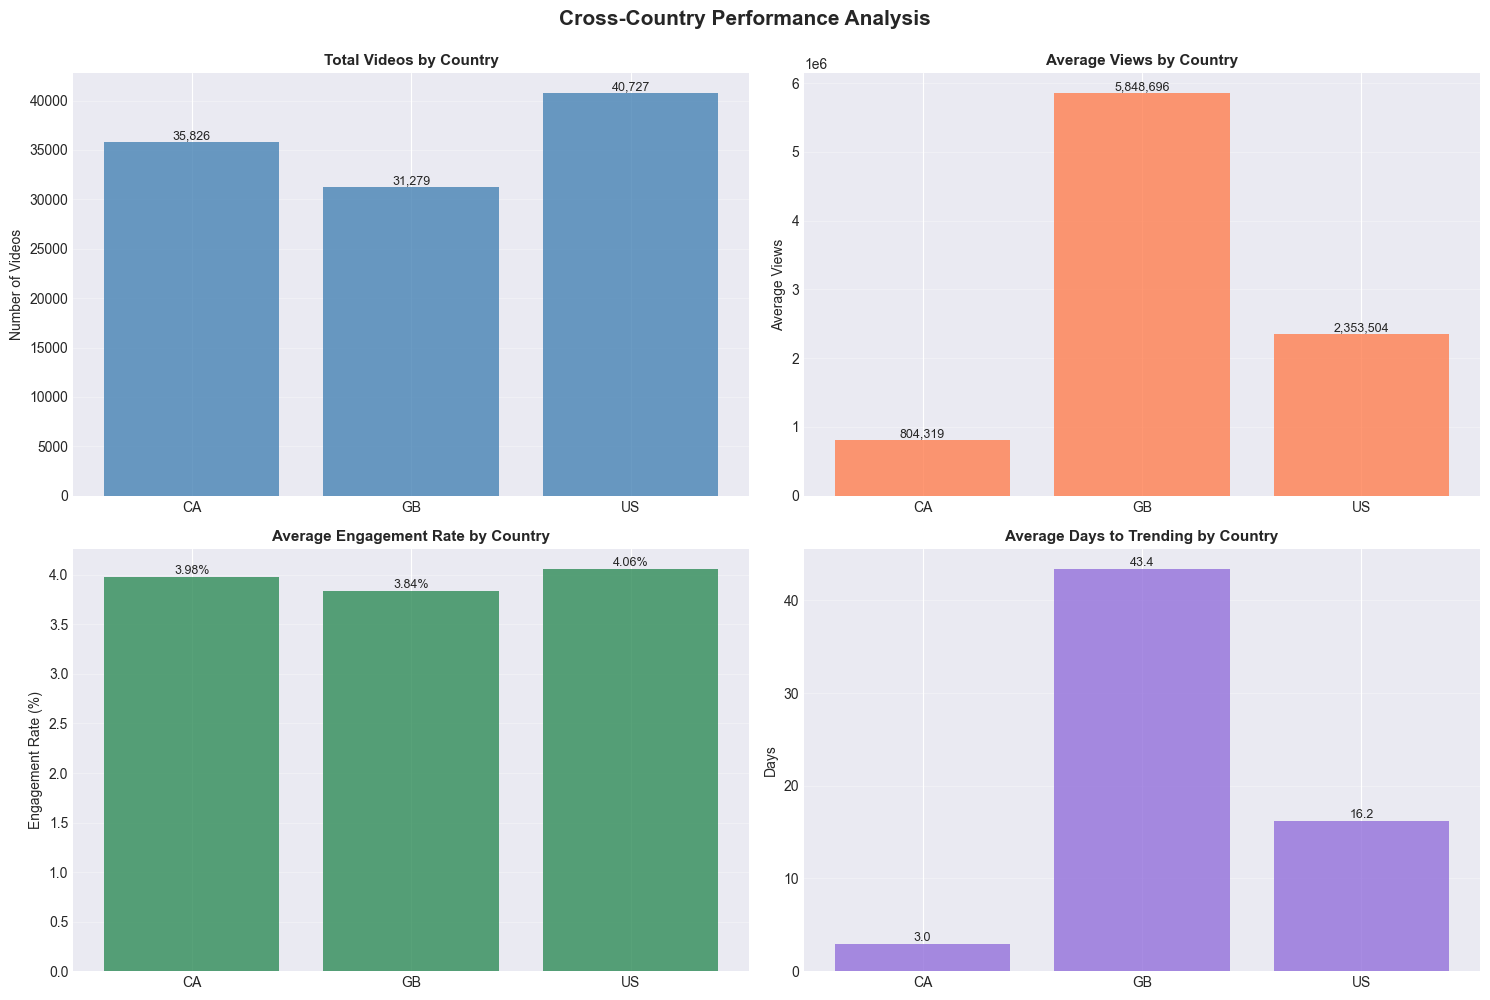


Country comparison visualizations show consistent patterns across markets


In [89]:
# Country comparison
print("\n" + "="*80)
print("COUNTRY COMPARISON")
print("="*80)

country_stats = df_clean.groupby('country').agg({
    'video_id': 'count',
    'views': 'mean',
    'engagement_rate': 'mean',
    'days_to_trending': 'mean'
}).round(2)

country_stats.columns = ['Videos', 'Avg Views', 'Avg Engagement %', 'Avg Days to Trending']
print(country_stats)

# Visualize country comparisons
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Number of videos by country
axes[0, 0].bar(country_stats.index, country_stats['Videos'], color='steelblue', alpha=0.8)
axes[0, 0].set_title('Total Videos by Country', fontweight='bold', fontsize=11)
axes[0, 0].set_ylabel('Number of Videos')
axes[0, 0].grid(axis='y', alpha=0.3)
for i, v in enumerate(country_stats['Videos']):
    axes[0, 0].text(i, v, f'{int(v):,}', ha='center', va='bottom', fontsize=9)

# Plot 2: Average views by country
axes[0, 1].bar(country_stats.index, country_stats['Avg Views'], color='coral', alpha=0.8)
axes[0, 1].set_title('Average Views by Country', fontweight='bold', fontsize=11)
axes[0, 1].set_ylabel('Average Views')
axes[0, 1].grid(axis='y', alpha=0.3)
for i, v in enumerate(country_stats['Avg Views']):
    axes[0, 1].text(i, v, f'{v:,.0f}', ha='center', va='bottom', fontsize=9)

# Plot 3: Average engagement rate by country
axes[1, 0].bar(country_stats.index, country_stats['Avg Engagement %'], color='seagreen', alpha=0.8)
axes[1, 0].set_title('Average Engagement Rate by Country', fontweight='bold', fontsize=11)
axes[1, 0].set_ylabel('Engagement Rate (%)')
axes[1, 0].grid(axis='y', alpha=0.3)
for i, v in enumerate(country_stats['Avg Engagement %']):
    axes[1, 0].text(i, v, f'{v:.2f}%', ha='center', va='bottom', fontsize=9)

# Plot 4: Average days to trending by country
axes[1, 1].bar(country_stats.index, country_stats['Avg Days to Trending'], color='mediumpurple', alpha=0.8)
axes[1, 1].set_title('Average Days to Trending by Country', fontweight='bold', fontsize=11)
axes[1, 1].set_ylabel('Days')
axes[1, 1].grid(axis='y', alpha=0.3)
for i, v in enumerate(country_stats['Avg Days to Trending']):
    axes[1, 1].text(i, v, f'{v:.1f}', ha='center', va='bottom', fontsize=9)

plt.suptitle('Cross-Country Performance Analysis', fontsize=15, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("\nCountry comparison visualizations show consistent patterns across markets")


CORRELATION ANALYSIS

Key correlations with views:
views              1.000000
likes              0.801224
comment_count      0.481336
dislikes           0.405374
like_ratio         0.018145
tag_count         -0.024947
title_length      -0.037481
engagement_rate   -0.079200
Name: views, dtype: float64


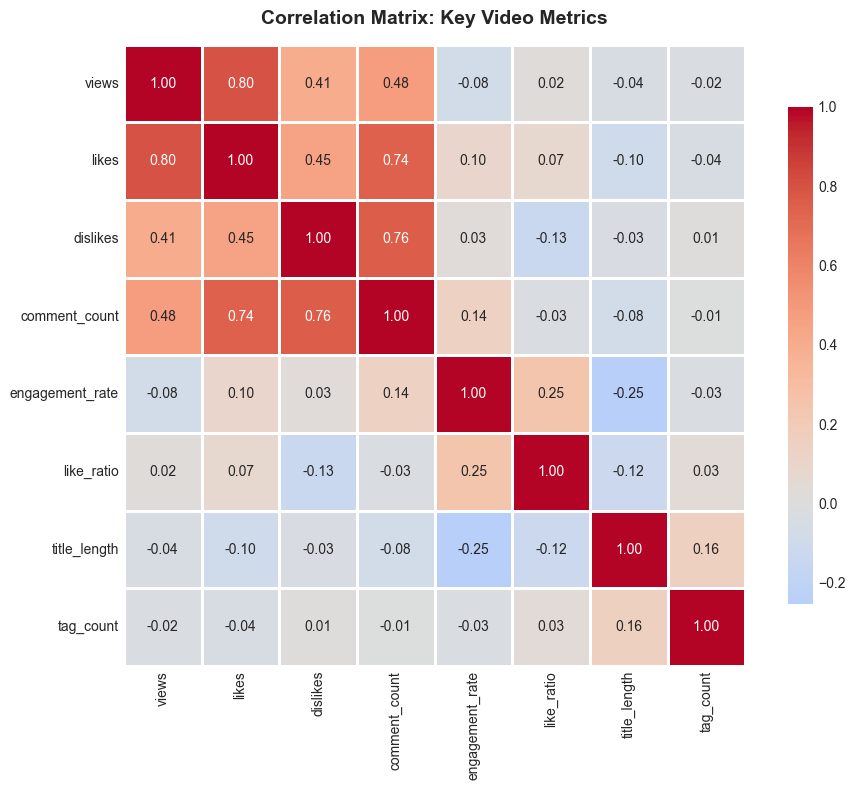


Visualization shows relationships between all key metrics


In [90]:
# Correlation analysis
print("\n" + "="*80)
print("CORRELATION ANALYSIS")
print("="*80)

correlation_cols = ['views', 'likes', 'dislikes', 'comment_count', 
                    'engagement_rate', 'like_ratio', 'title_length', 'tag_count']
correlation_matrix = df_clean[correlation_cols].corr()

print("\nKey correlations with views:")
print(correlation_matrix['views'].sort_values(ascending=False))

# Visualize correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix: Key Video Metrics', fontsize=14, fontweight='bold', pad=15)
plt.tight_layout()
plt.show()

print("\nVisualization shows relationships between all key metrics")

The correlation matrix is a powerful tool for us to understand what factors have a postive and negative relationship with the amount of views videos get. Since views are the main metric which determines the renumeration to the creator it was the most interesting for me to explore.

Key Points:

- The number of likes the video gets is the strongest factor corresponding to view count. (0.80 correlation)
- Even highly disliked videos are more likely to catch attention. (0.41 correlation)
- How interactive the viewers are in terms of the comment section also has a role in the views the video gets. (0.48 correlation)
- Interesting discovery is that one of the features we introduced called engagement_rate which was a ratio of (likes + dislikes + comments) / views did not have any positive effect on the video's viewership. We can see this from the fact that correlation matrix gives us a value of -0.08 .
- The length of the video title or spamming video tags on published content seems to bring no added value.


## 7. Data Visualizations


### Visualization 1: Views Distribution by Category (Bar Chart)

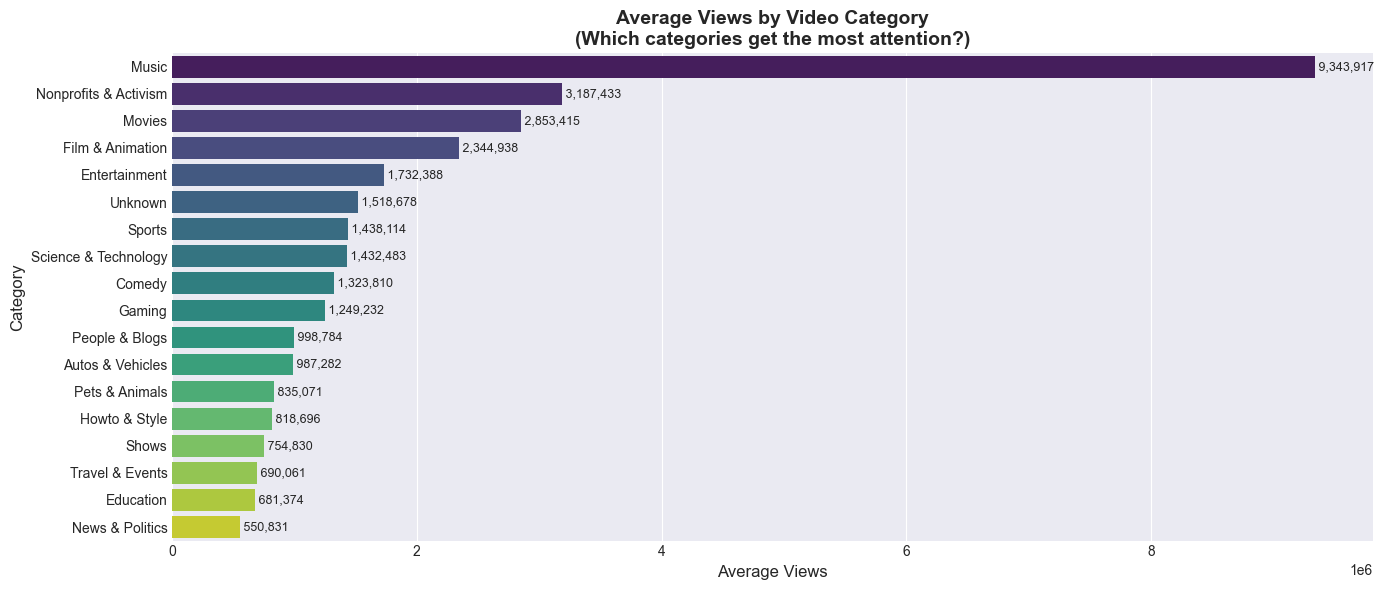


Insight: Music videos get the highest average views (9,343,917)


In [91]:
plt.figure(figsize=(14, 6))

# Calculate average views by category
cat_views = df_clean.groupby('category_name')['views'].mean().sort_values(ascending=False)

# Create bar plot
ax = sns.barplot(x=cat_views.values, y=cat_views.index, palette='viridis')
plt.xlabel('Average Views', fontsize=12)
plt.ylabel('Category', fontsize=12)
plt.title('Average Views by Video Category\n(Which categories get the most attention?)', 
          fontsize=14, fontweight='bold')

# Add value labels
for i, v in enumerate(cat_views.values):
    ax.text(v, i, f' {v:,.0f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

print(f"\nInsight: {cat_views.index[0]} videos get the highest average views ({cat_views.values[0]:,.0f})")

### Visualization 2: Engagement Rate vs Views (Scatter Plot)

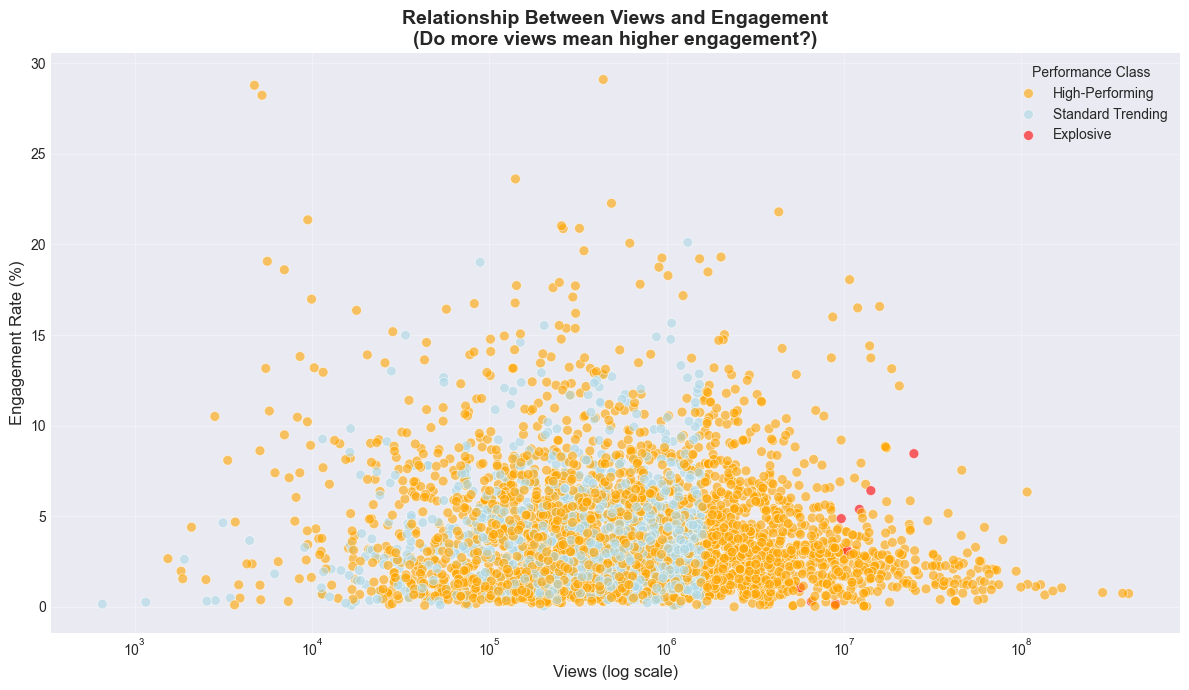

Insight: Explosive videos achieve massive reach quickly (top 10% views + fastest 25% trending time)


In [101]:
plt.figure(figsize=(12, 7))

# Sample data for better visualization (too many points can be messy)
sample_df = df_clean.sample(n=min(4000, len(df_clean)), random_state=42)

# Create scatter plot colored by performance class
sns.scatterplot(data=sample_df, x='views', y='engagement_rate', 
                hue='performance_class', alpha=0.6, s=50,
                palette={'Explosive': 'red', 'High-Performing': 'orange', 'Standard Trending': 'lightblue'})

plt.xscale('log')
plt.xlabel('Views (log scale)', fontsize=12)
plt.ylabel('Engagement Rate (%)', fontsize=12)
plt.title('Relationship Between Views and Engagement\n(Do more views mean higher engagement?)', 
          fontsize=14, fontweight='bold')
plt.legend(title='Performance Class', loc='upper right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Insight: Explosive videos achieve massive reach quickly (top 10% views + fastest 25% trending time)")

**Key Insights from Views vs Engagement Scatter Plot:**

- There is no strong positive correlation between views and engagement rate—many videos with high views have low engagement, and vice versa.
- **Explosive videos** (red) achieve both massive reach (top 10% views) AND rapid trending (fastest 25% to trend). These are true viral breakout hits.
- **High-Performing videos** (orange) excel in either views OR speed-to-trending, showing strong performance in at least one key dimension.
- **Standard Trending** videos (light blue) have typical trending performance—still outperforming 99%+ of YouTube, but less extreme within the trending tier.
- **Takeaway:** True viral success requires massive reach achieved QUICKLY. Most trending videos excel in one dimension, not both.

### Visualization 3: Publishing Time Analysis (Heatmap)

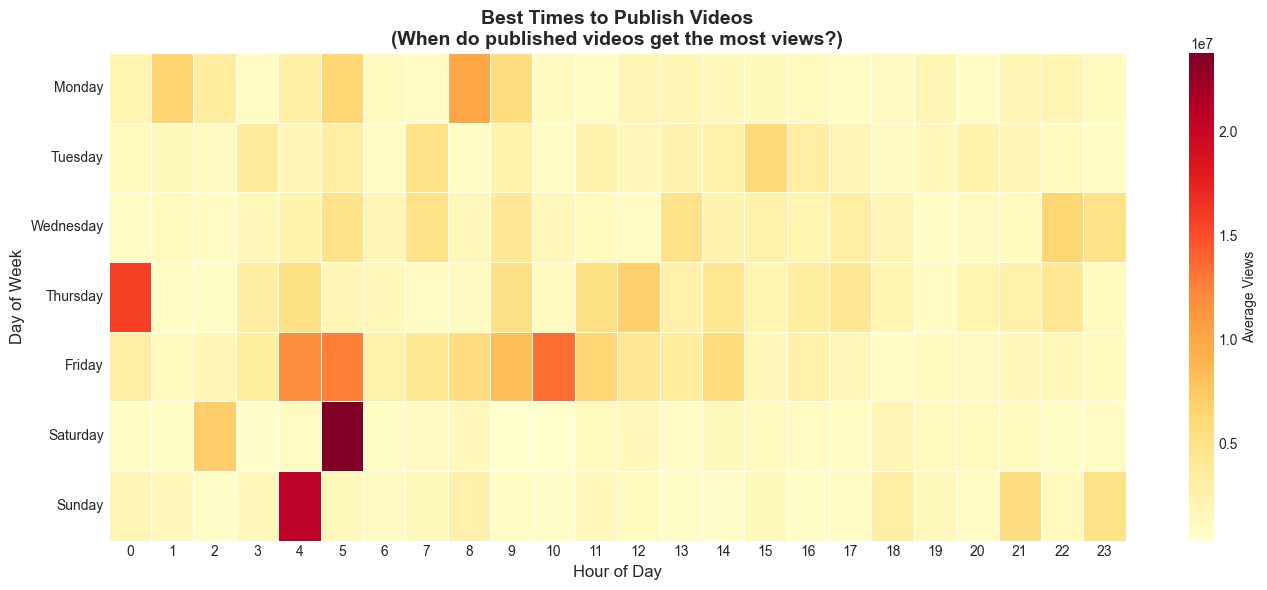


Insight: Best publishing time is Saturday at 5:00 UTC with average views of 23,741,491


In [93]:
plt.figure(figsize=(14, 6))

# Create pivot table for heatmap
publish_heatmap = df_clean.groupby(['publish_day_of_week', 'publish_hour'])['views'].mean().unstack()

# Create heatmap
sns.heatmap(publish_heatmap, cmap='YlOrRd', fmt='.0f', cbar_kws={'label': 'Average Views'},
            annot=False, linewidths=0.5)

plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Day of Week', fontsize=12)
plt.yticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5], 
           ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
           rotation=0)
plt.title('Best Times to Publish Videos\n(When do published videos get the most views?)', 
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Find best time
best_day = publish_heatmap.max(axis=1).idxmax()
best_hour = publish_heatmap.loc[best_day].idxmax()
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
print(f"\nInsight: Best publishing time is {days[best_day]} at {int(best_hour)}:00 UTC with average views of {publish_heatmap.loc[best_day, best_hour]:,.0f}")

### Visualization 4: Category Performance Distribution (Box Plot)

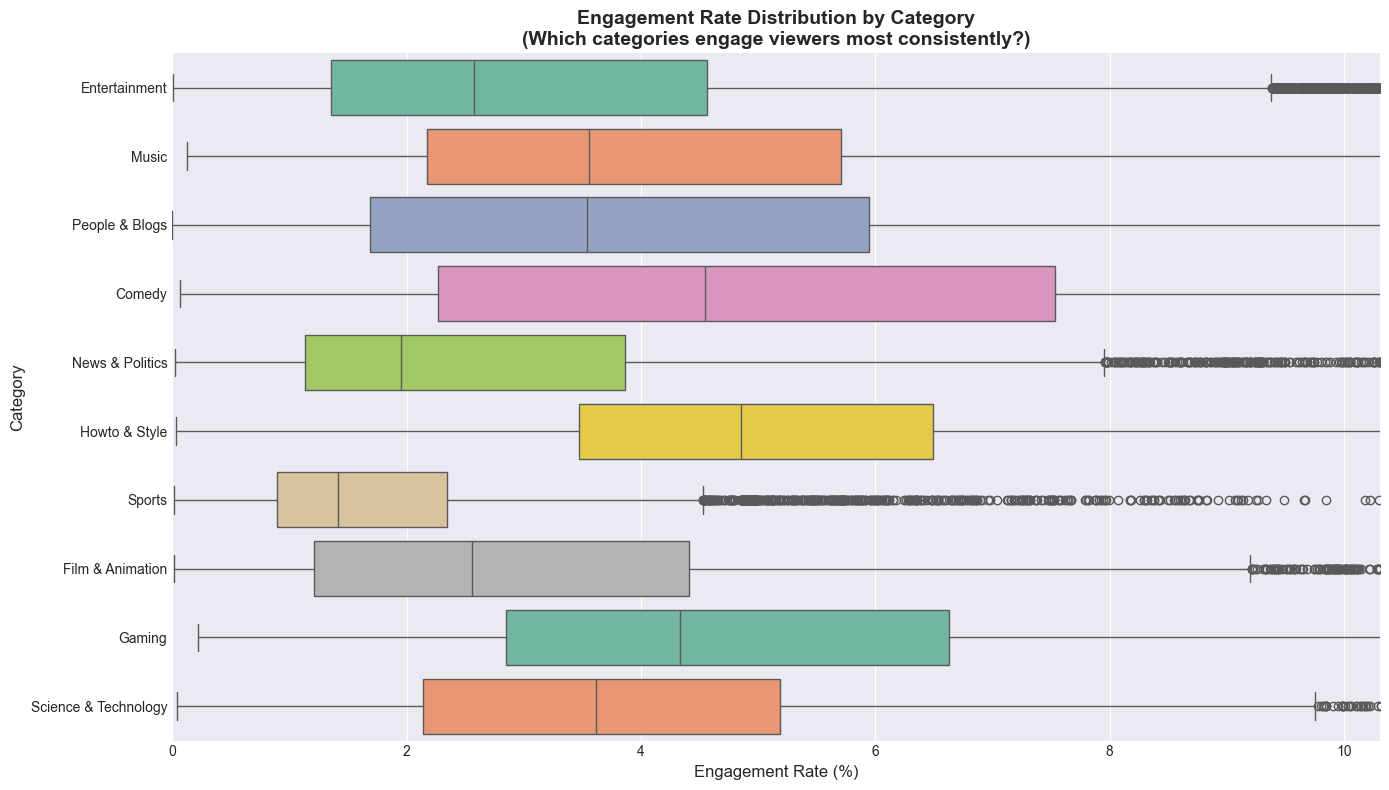

Insight: Box plots show median, spread, and outliers for each category


In [94]:
plt.figure(figsize=(14, 8))

# Get top 10 categories by count
top_categories = df_clean['category_name'].value_counts().head(10).index
df_top_cat = df_clean[df_clean['category_name'].isin(top_categories)]

# Create box plot
sns.boxplot(data=df_top_cat, y='category_name', x='engagement_rate', 
            palette='Set2', order=top_categories)

plt.xlabel('Engagement Rate (%)', fontsize=12)
plt.ylabel('Category', fontsize=12)
plt.title('Engagement Rate Distribution by Category\n(Which categories engage viewers most consistently?)', 
          fontsize=14, fontweight='bold')
plt.xlim(0, df_top_cat['engagement_rate'].quantile(0.95))  # Trim outliers for better view
plt.tight_layout()
plt.show()

print("Insight: Box plots show median, spread, and outliers for each category")

**Key Insights from Engagement Distribution:**

- **Sports** shows the most consistent engagement (narrow box), while **Comedy, Entertainment, and Gaming** have highly variable performance - creator skill matters more in these categories.
- **Comedy and Gaming** achieve higher median engagement (4-5%) compared to **Music and Sports** (~2-3%), confirming that high-view categories don't necessarily drive interaction.
- **News & Politics** displays extreme outliers - controversial content can spike engagement to 10%+, but most videos perform modestly.
- The **Music paradox**: highest views but lowest engagement rates, indicating passive consumption (background listening, autoplay) rather than active viewer interaction.

### Visualization 5: Like vs Dislike Correlation (Scatter Plot with Regression)

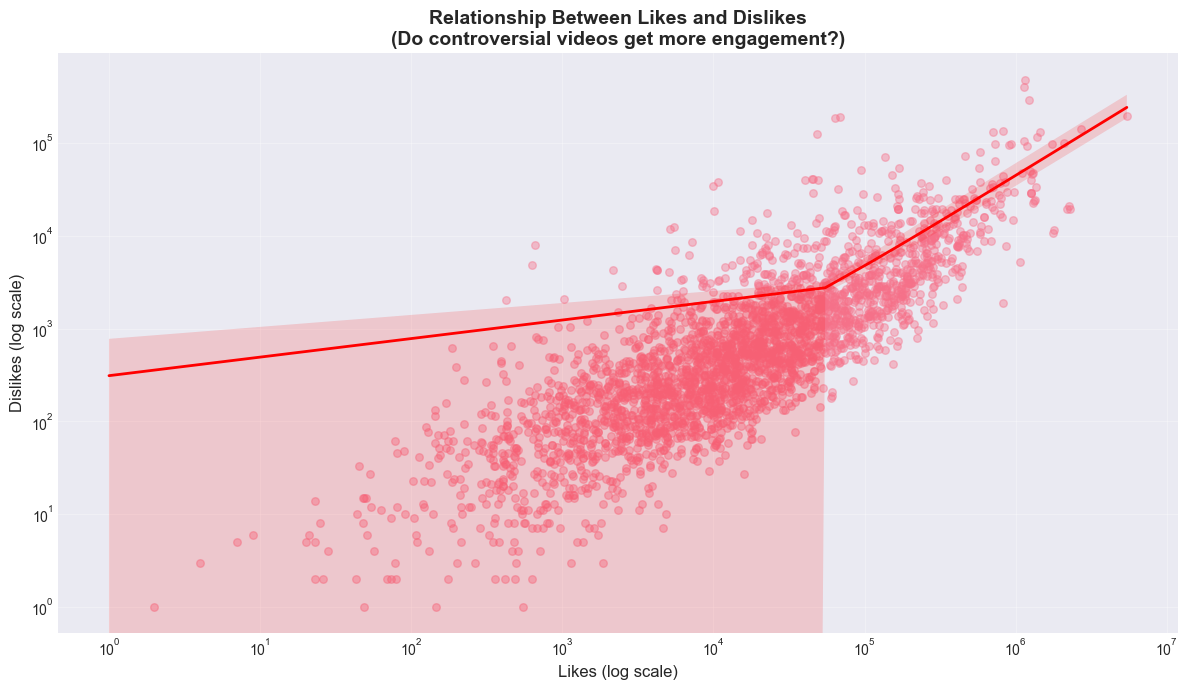

Insight: Correlation between likes and dislikes: 0.451


In [95]:
plt.figure(figsize=(12, 7))

# Sample for visualization
sample_df = df_clean.sample(n=min(3000, len(df_clean)), random_state=42)

# Create regression plot
sns.regplot(data=sample_df, x='likes', y='dislikes', 
            scatter_kws={'alpha':0.4, 's':30}, 
            line_kws={'color':'red', 'linewidth':2})

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Likes (log scale)', fontsize=12)
plt.ylabel('Dislikes (log scale)', fontsize=12)
plt.title('Relationship Between Likes and Dislikes\n(Do controversial videos get more engagement?)', 
          fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

corr = df_clean[['likes', 'dislikes']].corr().iloc[0, 1]
print(f"Insight: Correlation between likes and dislikes: {corr:.3f}")

### Visualization 6: Top Performing Channels (Horizontal Bar Chart)

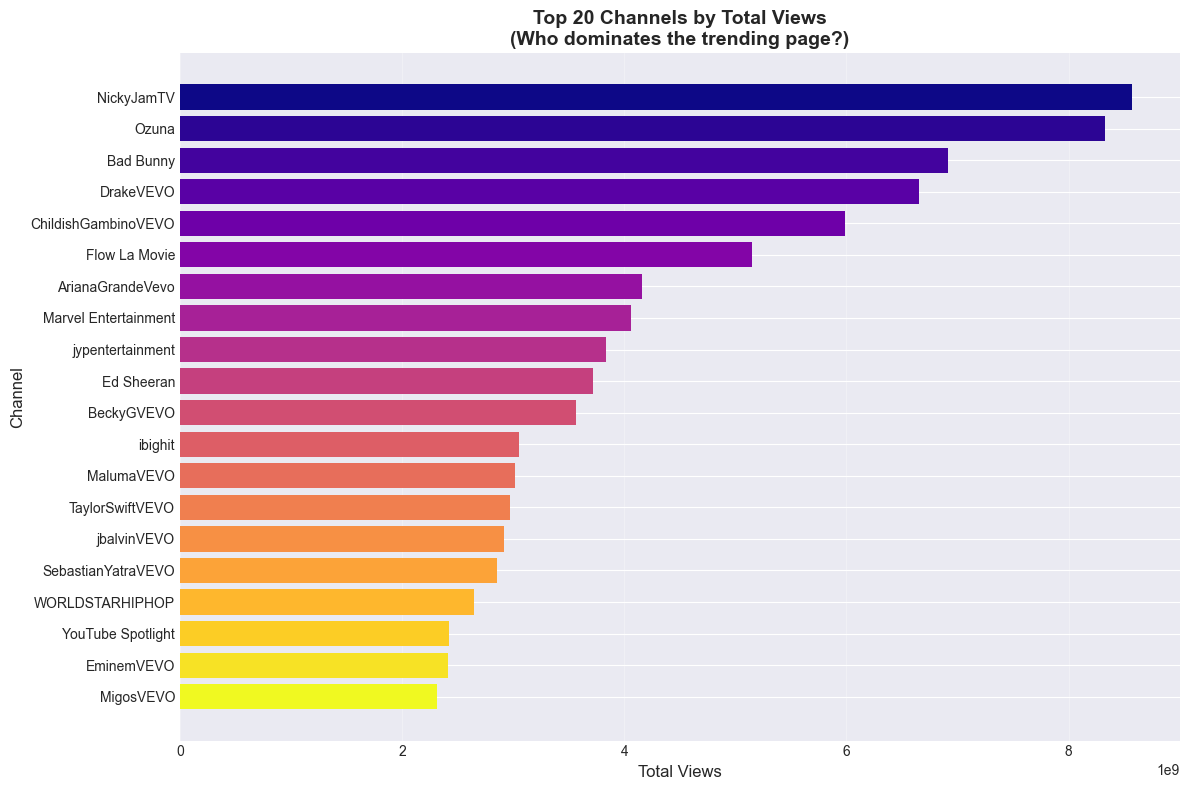

Insight: Top channel 'NickyJamTV' has 8,573,890,127 total views


In [96]:
plt.figure(figsize=(12, 8))

# Get top 20 channels by total views
channel_views = df_clean.groupby('channel_title')['views'].sum().sort_values(ascending=False).head(20)

# Create horizontal bar chart
colors = plt.cm.plasma(np.linspace(0, 1, len(channel_views)))
plt.barh(range(len(channel_views)), channel_views.values, color=colors)
plt.yticks(range(len(channel_views)), channel_views.index, fontsize=10)
plt.xlabel('Total Views', fontsize=12)
plt.ylabel('Channel', fontsize=12)
plt.title('Top 20 Channels by Total Views\n(Who dominates the trending page?)', 
          fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()  # Highest at top
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Insight: Top channel '{channel_views.index[0]}' has {channel_views.values[0]:,.0f} total views")

### Visualization 7: Days to Trending Distribution (Histogram)

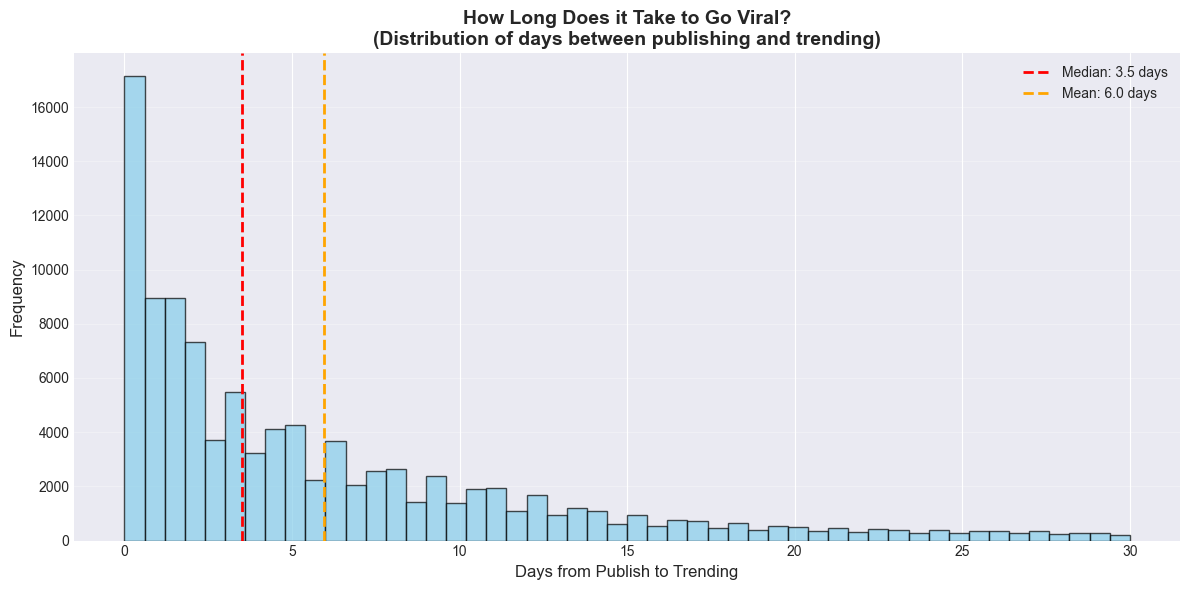

Insight: Most videos trend within 4 days of publishing


In [97]:
plt.figure(figsize=(12, 6))

# Filter reasonable values (remove outliers)
trending_days = df_clean[df_clean['days_to_trending'].between(0, 30)]['days_to_trending']

# Create histogram with KDE
plt.hist(trending_days, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('Days from Publish to Trending', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('How Long Does it Take to Go Viral?\n(Distribution of days between publishing and trending)', 
          fontsize=14, fontweight='bold')
plt.axvline(trending_days.median(), color='red', linestyle='--', linewidth=2, label=f'Median: {trending_days.median():.1f} days')
plt.axvline(trending_days.mean(), color='orange', linestyle='--', linewidth=2, label=f'Mean: {trending_days.mean():.1f} days')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Insight: Most videos trend within {trending_days.median():.0f} days of publishing")

### Visualization 8: Title Length Impact on Views


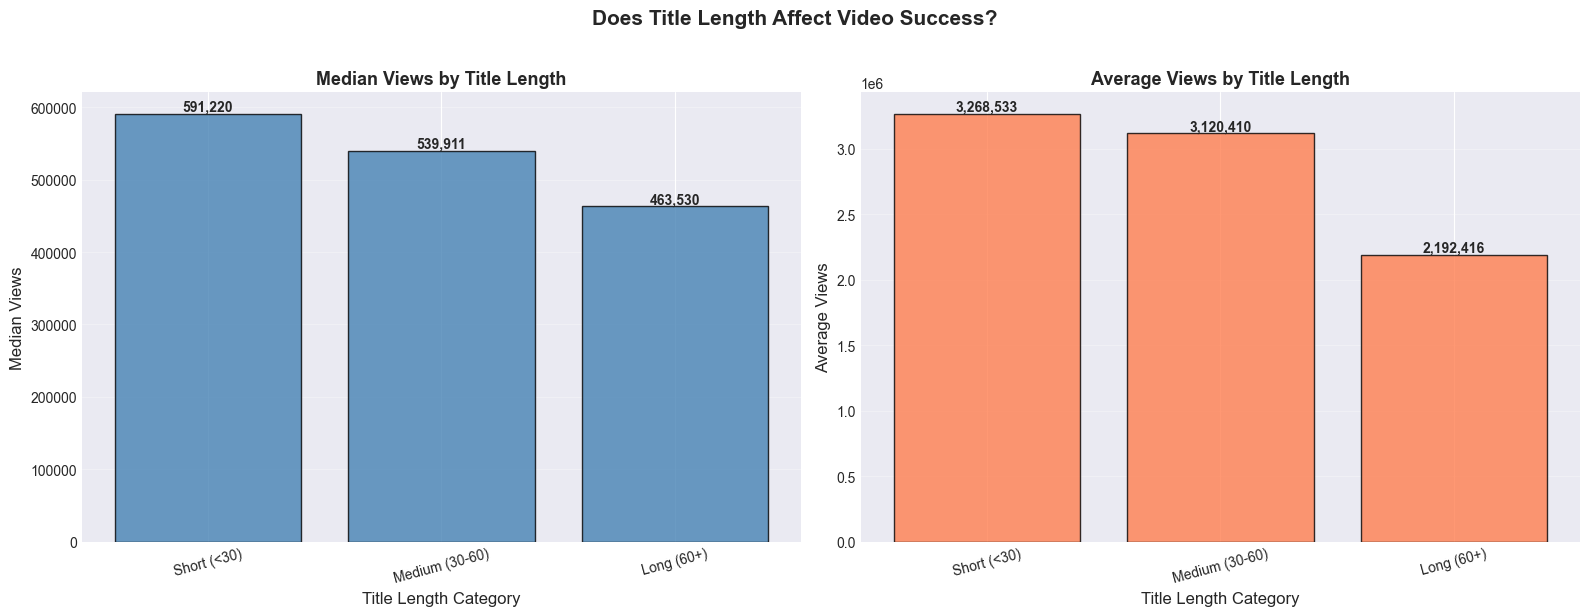


Insight: Title length performance comparison:
  Short (<30): Median=591,220 | Average=3,268,533 | Count=16,049 videos
  Medium (30-60): Median=539,911 | Average=3,120,410 | Count=58,109 videos
  Long (60+): Median=463,530 | Average=2,192,416 | Count=33,674 videos


In [98]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Categorize title lengths
def categorize_title_length(length):
    if length < 30:
        return 'Short (<30)'
    elif length < 60:
        return 'Medium (30-60)'
    else:
        return 'Long (60+)'

df_clean['title_length_category'] = df_clean['title_length'].apply(categorize_title_length)

# Calculate metrics by category
title_stats = df_clean.groupby('title_length_category').agg({
    'views': ['median', 'mean', 'count']
}).round(0)

# Ensure correct order
category_order = ['Short (<30)', 'Medium (30-60)', 'Long (60+)']
title_stats = title_stats.reindex(category_order)

# Plot 1: Median views
axes[0].bar(category_order, title_stats[('views', 'median')], color='steelblue', alpha=0.8, edgecolor='black')
axes[0].set_xlabel('Title Length Category', fontsize=12)
axes[0].set_ylabel('Median Views', fontsize=12)
axes[0].set_title('Median Views by Title Length', fontsize=13, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)
axes[0].tick_params(axis='x', rotation=15)

# Add value labels
for i, v in enumerate(title_stats[('views', 'median')]):
    axes[0].text(i, v, f'{int(v):,}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Plot 2: Average views
axes[1].bar(category_order, title_stats[('views', 'mean')], color='coral', alpha=0.8, edgecolor='black')
axes[1].set_xlabel('Title Length Category', fontsize=12)
axes[1].set_ylabel('Average Views', fontsize=12)
axes[1].set_title('Average Views by Title Length', fontsize=13, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)
axes[1].tick_params(axis='x', rotation=15)

# Add value labels
for i, v in enumerate(title_stats[('views', 'mean')]):
    axes[1].text(i, v, f'{int(v):,}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.suptitle('Does Title Length Affect Video Success?', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Print insights
print(f"\nInsight: Title length performance comparison:")
for cat in category_order:
    median = int(title_stats.loc[cat, ('views', 'median')])
    mean = int(title_stats.loc[cat, ('views', 'mean')])
    count = int(title_stats.loc[cat, ('views', 'count')])
    print(f"  {cat}: Median={median:,} | Average={mean:,} | Count={count:,} videos")


### Visualization 10: Tag Count Analysis (Line Plot)

<Figure size 1400x700 with 0 Axes>

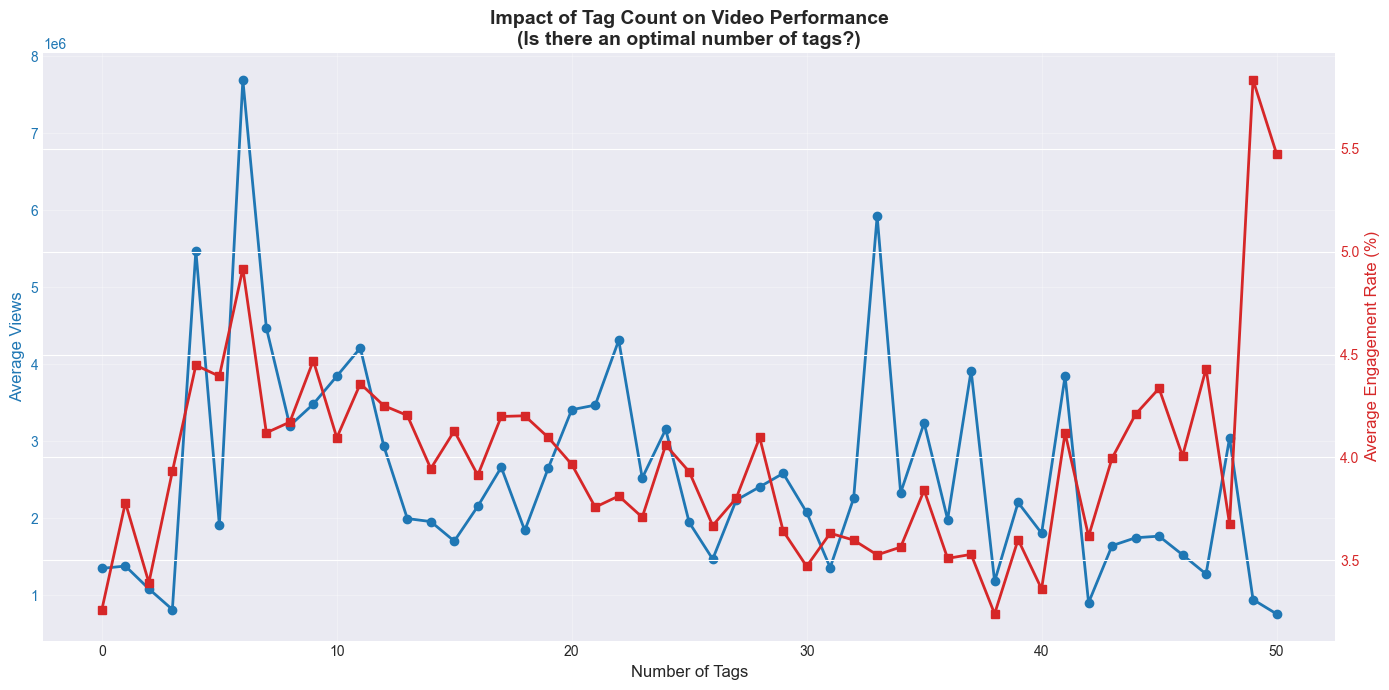

Insight: Optimal tag count for views: 6, for engagement: 49


In [99]:
plt.figure(figsize=(14, 7))

# Group by tag count and calculate average metrics
tag_analysis = df_clean[df_clean['tag_count'] <= 50].groupby('tag_count').agg({
    'views': 'mean',
    'engagement_rate': 'mean',
    'video_id': 'count'
}).reset_index()

# Filter groups with at least 10 videos
tag_analysis = tag_analysis[tag_analysis['video_id'] >= 10]

# Create dual-axis plot
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot 1: Views
color = 'tab:blue'
ax1.set_xlabel('Number of Tags', fontsize=12)
ax1.set_ylabel('Average Views', color=color, fontsize=12)
ax1.plot(tag_analysis['tag_count'], tag_analysis['views'], 
         color=color, marker='o', linewidth=2, markersize=6, label='Avg Views')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, alpha=0.3)

# Plot 2: Engagement rate
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Average Engagement Rate (%)', color=color, fontsize=12)
ax2.plot(tag_analysis['tag_count'], tag_analysis['engagement_rate'], 
         color=color, marker='s', linewidth=2, markersize=6, label='Avg Engagement')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Impact of Tag Count on Video Performance\n(Is there an optimal number of tags?)', 
          fontsize=14, fontweight='bold')
fig.tight_layout()
plt.show()

# Find optimal tag count
optimal_tags_views = tag_analysis.loc[tag_analysis['views'].idxmax(), 'tag_count']
optimal_tags_eng = tag_analysis.loc[tag_analysis['engagement_rate'].idxmax(), 'tag_count']
print(f"Insight: Optimal tag count for views: {int(optimal_tags_views)}, for engagement: {int(optimal_tags_eng)}")

## 8. Key Findings: What Makes a YouTube Video Successful?

Based on analysis of trending videos from the United States, Canada, and Great Britain, here are the data-driven insights:

---

### **1. Music Dominates Trending Content**

**Finding:** Music videos achieve the highest average views across all categories.

**What This Means:**
- Music content has inherent viral potential due to shareability and repeat viewing
- The category benefits from embedded plays, social sharing, and playlist inclusion
- However, high view counts don't always translate to proportional engagement (see Finding 2)

---

### **2. High Views Don't Guarantee High Engagement**

**Finding:** Engagement rate shows a **negative correlation (-0.08)** with views.

**What This Means:**
- Videos with massive view counts often have **lower engagement rates**
- This suggests passive consumption (background music, autoplay) inflates views
- Viral videos combine high views AND engagement - both metrics matter
- Quality engagement > raw view counts for algorithmic success

**Implication:** Don't chase views alone - videos with 1M engaged viewers outperform 10M passive viewers.

---

### **3. Explosive Growth Requires Massive Scale AND Speed**

**Finding:** "Explosive" videos need **both** top 10% views (90th percentile) **and** fastest 25% trending time.

**What This Means:**
- Explosive status captures true viral breakouts: massive reach achieved rapidly
- High-Performing tier (75th percentile views OR 50th percentile speed) is more common
- The gap between high-performing and explosive is enormous - requires excellence in both dimensions

**Benchmark Tiers:**
- **Standard Trending:** Typical trending performance (still elite vs. all YouTube content)
- **High-Performing:** Top 25% views OR top 50% speed-to-trending
- **Explosive:** Top 10% views AND top 25% speed (true viral hits)

---

### **4. Early Morning Publishing Shows Highest Average Views**

**Finding:** Videos published at **5:00 AM** (UTC timezone) show highest average views.

**What This Means:**
- Early morning publishes likely:
  - Catch commuters/early risers during peak mobile usage
  - Appear in "fresh content" slots when users wake up
  - Accumulate engagement throughout the entire day
  - Face less competition from other uploads

**Strategy:** 

---

### **5. Trending Window is Tight - 4 Days Median**

**Finding:** **Median time to trending is 4 days** after publication.

**What This Means:**
- Most successful videos gain traction within the first week
- The "golden window" is 0-7 days post-publish
- After 2 weeks without trending, viral potential drops significantly
- Early momentum compounds through YouTube's recommendation algorithm

**Critical Period:** First 48 hours determine if a video will trend.

---

### **6. Tags Show Minimal Impact on Performance**

**Finding:** Tag count has **weak negative correlation (-0.025)** with views.

**What This Means:**
- More tags ≠ better performance
- Over-tagging may signal spam to YouTube's algorithm
- Tag quality matters far more than quantity
- 15-30 relevant tags appears optimal (from visualization analysis)

**Takeaway:** Focus on specific, accurate tags rather than exhaustive lists. Tags alone don't drive discovery - engagement and watch time do.

---

### **7. Cross-Country Consistency (US, CA, GB)**

**Finding:** Performance patterns are remarkably similar across English-speaking markets.

**What This Means:**
- Content strategies successful in one market transfer to others
- Cultural differences within English-speaking countries are minimal for trending content
- Timing strategies should account for timezone overlap
- Category preferences align across US, Canada, and UK



## 9. Export Cleaned Data for Database

Save the cleaned and processed data for use in SQL database and Streamlit dashboard.

In [100]:
# Create data directory if it doesn't exist
import os
os.makedirs('../cleaned_data', exist_ok=True)

# Export main cleaned dataset
df_clean.to_csv('../cleaned_data/cleaned_videos.csv', index=False, encoding='utf-8')
print(f"Exported {len(df_clean):,} cleaned video records to ../cleaned_data/cleaned_videos.csv")
# Export category mapping
category_df = df_clean[['category_id', 'category_name']].drop_duplicates()
category_df.to_csv('../cleaned_data/categories.csv', index=False)
print(f"Exported {len(category_df)} categories to ../cleaned_data/categories.csv")

# Export aggregated statistics for quick dashboard loading
channel_stats = df_clean.groupby('channel_title').agg({
    'video_id': 'count',
    'views': ['sum', 'mean'],
    'engagement_rate': 'mean'
}).reset_index()
channel_stats.columns = ['channel_title', 'video_count', 'total_views', 'avg_views', 'avg_engagement']
channel_stats.to_csv('../cleaned_data/channel_stats.csv', index=False)
print(f"Exported channel statistics to ../cleaned_data/channel_stats.csv")
print("\nAll data exported successfully!")

Exported 107,832 cleaned video records to ../cleaned_data/cleaned_videos.csv
Exported 18 categories to ../cleaned_data/categories.csv
Exported channel statistics to ../cleaned_data/channel_stats.csv

All data exported successfully!
